In [ ]:
import sys
import gymnasium
import os
import pandas as pd
from matplotlib import pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor

from building_energy_storage_simulation import Simulation, Environment

# Applying Reiforcement Learning Using Stable Baselines 3


In [ ]:
RL_PATH = 'rl_example/'
os.makedirs(RL_PATH, exist_ok=True)

# Create Environment
env = Environment(solar_power_installed=300)
# Wrap with Monitor() so a log of the training is saved 
env = Monitor(env, filename=RL_PATH)
# Warp with DummyVecEnc() so the observations and reward can be normalized using VecNormalize()
env = DummyVecEnv([lambda: env])
env = VecNormalize(env, norm_obs=True, norm_reward=True)

In [ ]:
# Train with PPO :-)
model = PPO("MlpPolicy", env, verbose=1, gamma=0.95)
model.learn(total_timesteps=50000)
# Store the trained Model and environment stats (which are needed as we are standardizing the observations and reward using VecNormalize())
model.save(RL_PATH + 'model')
env.save(RL_PATH + 'env.pkl')

# Evaluation

In [ ]:
# Plot the training process
training_log = pd.read_csv(RL_PATH + 'monitor.csv', skiprows=1)
training_log['r'].plot()

In [ ]:
env.training = False

actions, observations, electricity_consumption, excess_energy, rewards = ([], [], [], [], [])
done = False
obs = env.reset()
while not done:
        action = model.predict(obs, deterministic=True)
        obs, r, done, info = env.step([action[0][0]])

        actions.append(action[0][0][0])
        original_reward = env.get_original_reward()[0]
        original_obs = env.get_original_obs()[0]
        observations.append(original_obs)
        electricity_consumption.append(info[0]['electricity_consumption'])
        excess_energy.append(info[0]['excess_energy'])
        rewards.append(r)
        
trajectory = pd.DataFrame({
        'action': actions,
        'observations': observations,
        'electricity_consumption': electricity_consumption,
        'excess_energy': excess_energy,
        'reward': rewards
    })        

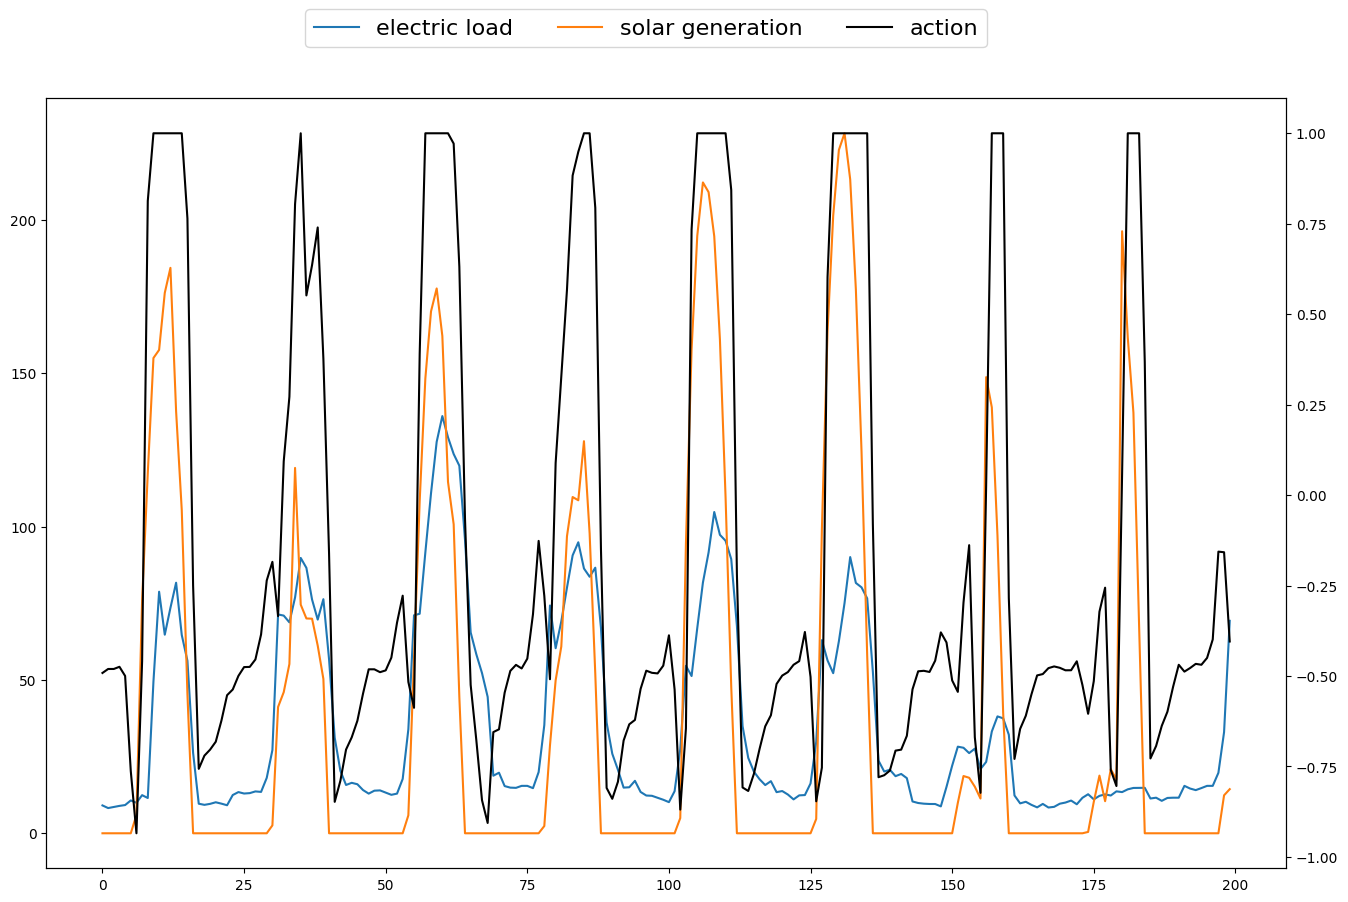

In [15]:
plot_data = trajectory[0:200]
observation_df = plot_data['observations'].apply(pd.Series)

plt.rcParams["figure.figsize"] = (16,10)

fig, ax = plt.subplots()
#ax.plot(observation_df[0], label = 'state of charge')
ax.plot(observation_df[1], label = 'electric load')
ax.plot(observation_df[5], label = 'solar generation')
#ax.plot(plot_data['excess_energy'], label = 'excess energy')
#ax.plot(plot_data['electricity_consumption'], label = 'electricity consumption')

ax1 = ax.twinx()
ax1.plot(plot_data['action'], label = 'action', color = 'black')
fig.legend(bbox_to_anchor=[0.5, 0.95], loc = 'center', ncol=5, prop={'size': 16})

# Compare to Baseline

In [ ]:
env.training = False

electricity_consumption = []
done = False
obs = env.reset()
while not done:
        action = model.predict(obs, deterministic=True)
        obs, r, done, info = env.step([action[0][0]])
        electricity_consumption.append(info[0]['electricity_consumption'])

electricity_consumption = sum(electricity_consumption)

In [ ]:
env.training = False

baseline_electricity_consumption = []
done = False
obs = env.reset()
while not done:
        # Always taking noop as action. This is the electricity demand if there would be no battery
        action = [0]
        obs, r, done, info = env.step(action)
        baseline_electricity_consumption.append(info[0]['electricity_consumption'])

baseline_electricity_consumption = sum(baseline_electricity_consumption)

In [ ]:
# how much energy did we save by utilizing the battery?
electricity_consumption / baseline_electricity_consumption